# Bayesian inference for oceanographers
# Correlation

Correlations are a frequently used approach to understand the relationships between data series. Bayesian inference provides a framework for the estimation of correlation coefficients along with the uncertainty in this estimation. In this post I set out an example of how you can apply Bayesian methods to estimate correlation and uncertainty in your data.  I begin with an idealised example, before showing how it works for real ocean data.

First, we need to import some packages. These can be installed using pip or conda on your system.


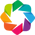

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Data analysis packages
import numpy as np
import xarray as xr
import pandas as pd
from scipy import signal
import pymc3 as pm
import theano
import pickle

# Visualisation imports
import holoviews as hv
import bokeh
from bokeh.plotting import figure, show

import nssh.nssh_mods.bayes_methods as bm
# Set visualisation options
hv.notebook_extension('bokeh')
bokeh.io.output_notebook()

%load_ext autoreload
%autoreload 2

## Idealised example
We first look at an idealised example where we create a dataset that is generated using NumPy's built in random number generator for a bivariate normal distribution:
$$ (x,y) \sim \mathcal{N}([\mu_{1},\mu_{2}],\Sigma)$$
where the $\mu_{i}$ values are the means and the covariance matrix is
$$\Sigma = \begin{bmatrix}
    \sigma_{1}^{2} & \rho\sigma_{1}\sigma_{2} \\
     \rho\sigma_{1}\sigma_{2} & \sigma_{1}^{2} \\
\end{bmatrix}$$
The full set of parameters is thus the mean $\mu_{1}$ and variance $\sigma_{1}^{2}$ on the first dimension, the mean $\mu_{2}$ and variance $\sigma_{2}^{2}$ on the second dimension and the correlation $\rho$ that connects the two dimensions.

In [39]:
N = 20 # Number of data points in our idealised dataset
means = np.array([ 0 , 0]) # Mean values for our bivariate normal distribution
variances = np.array([1, 1]) # Variances for our bivariate normal distribution
# We will generate datasets with correlation - which we call rho - that ranges from -1 to 1
rho = np.arange(-1,1,3e-2)
rho = rho[1:] # The end points with -1 correlation leads to a degenerate correlation matrix, so we exclude it
data = np.empty( (N, 2, len( rho ) ) ) # Pre-allocate our idealised dataset
large_data = np.empty( (100, 2, len( rho ) ) ) # Pre-allocate a dataset with many more samples
#We loop over the range of rhos to create an idealised dataset for each value of rho
for idx,r in enumerate( rho ):
    covs = np.array( [[variances[0]**2,r*variances[0]*variances[1]],[r*variances[0]*variances[1], variances[1]**2]])
    data[:,:,idx] = np.random.multivariate_normal( means, covs, N)


## Inspecting the data
As ever, the first thing to do is inspect our data. To do this, we use the holoviews package to scatterplot the data for each value of rho.

To vary the values of $\rho$ you can use drag the slider or click on it and use the left/right arrows on your keyboard.  

In [31]:
%%output size=130 # Set figure size
%%opts Scatter (size=10)
scatter_dict = {r:hv.Scatter(data[:,:,idx]) for idx,r in enumerate(rho)} #Create a key-value pair for each rho
scatter = hv.HoloMap(scatter_dict, kdims=['Rho']) #Create a HoloMap with this dictionary
scatter # Create the scatter plot

:HoloMap   [Rho]
   :Scatter   [x]   (y)

The scatter plot shows that plenty of variability can occur with small sample sizes, even when the data is drawn from a bivariate normal distribution!

## Infer the correlation using Bayesian methods
As we have the data, we can now proceed to develop a Bayesian model for the correlation.  [In a previous post](http://braaannigan.github.io/bayes_moc_gaussian.html) we looked at fitting a normal distribution to a dataset. The correlation inference proceeds on a similar basis, with the difference that we fit a bivariate normal distribution to the dataset.

In order to infer $\rho$, we have to infer the full set of parameters $\mu_{1},\mu_{2},\sigma_{1},\sigma_{2}$ and $\rho$.

As in the previous post, we need to set prior distributions for the parameters.  In this case we say that we expect $\mu_{1}$ and $\mu_{2}$ to be somewhere in the range -2 to 2 and so set:
$$\mu_{i} \sim \mathcal{N}(0,1)$$
while we expect the variance to be order 1 and so set
$$\sigma_{i} \sim \mathcal{N}^{+}(0,3)$$
where the plus sign means that only the positive side of the distribution is taken.

We set the prior for the correlation as
$$\rho \sim \textrm{Uniform}(-1,1).$$

This prior assigns equal probability to any value of $\rho$ in the range -1 to 1 [though the best way to set the prior for correlations is a subject of discussion](https://stats.stackexchange.com/questions/86484/why-not-use-beta1-1-as-boundary-avoiding-prior-on-a-transformed-correlation-pa).

We perform the inference separately for each dataset that corresponds to a different value of $\rho$. As well as inferring the parameters, we will also generate some simulated data from our model.  We will use this simulated data to test our model below.

A word of warning: Bayesian inference is computationally expensive - performing the inference for 50-60 different values of $\rho$ can take a couple of hours.  For this reason, I've provided some small files with results of the inference.  In you are modifying the example below I recommend that you carry out the inference for just a few values of $\rho$ to begin with.

The next stage is to define the function where we perform the inference.

In [32]:
from pymc3 import Model, Uniform, Normal, MvNormal, HalfNormal, Deterministic, sample, traceplot
import theano.tensor as ttens

def correlation(x, y, 
                mu_prior = {'mean': 0, 'sd': 1}, sigma_prior = {'sd':3}, 
                rho_prior = {'lower':-1,'upper':1}):
    """Get the correlation between x and y
    Inputs:
    x,y - numpy arrays/pandas series of same length
    priors for the parameters
    Ouputs:
    trace - PyMC3 output with results of inference
    rho_range - dictionary setting out mean rho and 95% range
    simulate_data - data simulated under the model
    output trace and summary dictionary"""
    def covariance(sigma, rho):
        """Create the covariance matrix from the array sigma and scalar rho"""
        C = ttens.alloc(rho, 2, 2)
        C = ttens.fill_diagonal(C, 1.)
        S = ttens.diag(sigma)
        return ttens.nlinalg.matrix_dot(S, C, S)

    data = np.array([x,y]) # Create an array with the dataset
    with Model() as model:
        # Specify the priors for the means
        mu = Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd'], shape = 2) 
        # Specify the priors for the variances
        sigma = HalfNormal('sigma', sd = sigma_prior['sd'], shape = 2) 
        # Specify the priors for rho
        rho = Uniform('rho', lower = rho_prior['lower'], upper = rho_prior['upper']) 
        # Create the covariance matrix
        cov = Deterministic('cov', covariance(sigma, rho)) 
        # Specify the likelihood as a multi-variate normal distribution
        mult_n = MvNormal('mult_n', mu = mu, cov = cov, observed = data.T) 
        # Perform the inference and extract 1000 samples from the posterior distributions
        trace = pm.sample(draws = 1000) 
        # Save some summary statistics for each value of rho
        rho_range = {'mean':trace.get_values('rho').mean(),
                     '2.5':pm.stats.quantiles(trace)['rho'][2.5],
                     '97.5':pm.stats.quantiles(trace)['rho'][97.5]}
        # Simulate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return trace, rho_range, simulate_data


Bayesian inference can takes **ages** to run. For this reason, you can skip the next cell and just load the saved outputs of the inference in the following cell.

In [ ]:
# Pre-allocate an array to hold summary statstics for rho
rho_range = np.empty((len(rho),3)) 
# A list to hold the full set of outputs from the inference
trace_list = [] 
# An array to hold the data simulated under the model
simulated_data = np.empty( (1000,2,len(rho))) 

# Loop through each value of rho and perform the inference
for idx in np.arange(len(rho)): 
    print(idx)
    # Do the inference
    trace,out_dict, ppc = correlation(data[:,0,idx],data[:,1,idx]) 
    # Add the trace to the trace_list
    trace_list.append(trace) 
    # Delete the most recent trace
    del trace
    # Save the summary statistics
    rho_range[idx,0] = out_dict['2.5'] # Calculate the summary statistics
    rho_range[idx,1] = out_dict['mean']
    rho_range[idx,2] = out_dict['97.5']
    # Save the simulated data
    simulated_data[:,:,idx] = ppc['mult_n'] # Save the simulated data for this value of rho

0


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -48.487: 100%|██████████| 200000/200000 [00:34<00:00, 5808.82it/s]
Finished [100%]: Average ELBO = -48.494
INFO:pymc3:Finished [100%]: Average ELBO = -48.494
100%|██████████| 1000/1000 [00:04<00:00, 226.07it/s]


1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -47.965: 100%|██████████| 200000/200000 [00:34<00:00, 5881.09it/s]
Finished [100%]: Average ELBO = -47.99
INFO:pymc3:Finished [100%]: Average ELBO = -47.99
100%|██████████| 1000/1000 [00:04<00:00, 231.63it/s]


2


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -50.413: 100%|██████████| 200000/200000 [00:34<00:00, 5866.21it/s]
Finished [100%]: Average ELBO = -50.385
INFO:pymc3:Finished [100%]: Average ELBO = -50.385
100%|██████████| 1000/1000 [00:04<00:00, 228.29it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


3


Average ELBO = -55.93: 100%|██████████| 200000/200000 [00:34<00:00, 5794.39it/s] 
Finished [100%]: Average ELBO = -55.947
INFO:pymc3:Finished [100%]: Average ELBO = -55.947
100%|██████████| 1000/1000 [00:04<00:00, 229.66it/s]


4


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -48.421: 100%|██████████| 200000/200000 [00:34<00:00, 5879.86it/s]
Finished [100%]: Average ELBO = -48.384
INFO:pymc3:Finished [100%]: Average ELBO = -48.384
100%|██████████| 1000/1000 [00:04<00:00, 213.78it/s]


5


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -51.466: 100%|██████████| 200000/200000 [00:34<00:00, 5735.38it/s]
Finished [100%]: Average ELBO = -51.439
INFO:pymc3:Finished [100%]: Average ELBO = -51.439
100%|██████████| 1000/1000 [00:04<00:00, 228.54it/s]


6


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -57.613: 100%|██████████| 200000/200000 [00:34<00:00, 5808.55it/s]
Finished [100%]: Average ELBO = -57.633
INFO:pymc3:Finished [100%]: Average ELBO = -57.633
100%|██████████| 1000/1000 [00:04<00:00, 208.04it/s]


7


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -58.558: 100%|██████████| 200000/200000 [00:35<00:00, 5695.50it/s]
Finished [100%]: Average ELBO = -58.581
INFO:pymc3:Finished [100%]: Average ELBO = -58.581
100%|██████████| 1000/1000 [00:04<00:00, 233.37it/s]


8


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -63.469: 100%|██████████| 200000/200000 [00:34<00:00, 5799.97it/s]
Finished [100%]: Average ELBO = -63.459
INFO:pymc3:Finished [100%]: Average ELBO = -63.459
100%|██████████| 1000/1000 [00:04<00:00, 228.85it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


9


Average ELBO = -55.135: 100%|██████████| 200000/200000 [00:34<00:00, 5810.69it/s]
Finished [100%]: Average ELBO = -55.174
INFO:pymc3:Finished [100%]: Average ELBO = -55.174
100%|██████████| 1000/1000 [00:04<00:00, 228.12it/s]


10


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
  0%|          | 0/200000 [00:00<?, ?it/s]

In [34]:
import pickle
#np.save('rho_range',rho_range)
#pickle.dump(trace_list,open("trace_list","wb"))
#np.save("simulated_data",simulated_data)
rho_range = np.load('rho_range.npy')
simulated_data = np.load('simulated_data.npy')
trace_list = pickle.load(open("trace_list","rb"));

We now define a function to create a plot using Bokeh showing the correlation and its uncertainty.

In [33]:
def fill_between(x, y, y_lower, y_upper,real_data, title = 'None', ylabel = None, xlabel = None):
    """Make a bokeh plot to show the an uncertainty range"""
    #Have to append a reversed series for the patch coordinates
    band_x = np.append(x, x[::-1])
    band_y = np.append(y_lower, y_upper[::-1])
    p = figure(title= title, height = 700, width = 700)
    p.line(x, y, line_width = 2, color = 'blue')
    p.line(x, real_data, line_dash="4 4", line_width=1, color='gray')
    p.patch(band_x, band_y, color='firebrick', fill_alpha=0.5, line_color = "firebrick")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    p.xaxis.bounds = (-1,1)
    p.yaxis.bounds = (-1,1)
    show(p)

We call this plot using the $rho\_range$ array that contains the mean and uncertainty ranges.  We plot the true value of the correlation as a dashed line. As this is a Bokeh plot you can use the tools on the right to zoom in.

The aim is for the inferred correlation to be close to the true value at the dashed line.  We would also hope that the uncertainty would be spread evenly above and below the dashed line close to 0 and biased towards zero as the limits at -1 and +1 are approached.

In [35]:
fill_between(rho, rho_range[:,1], rho_range[:,0], rho_range[:,2], rho, title = 'Inferred correlation with uncertainty ranges', 
             xlabel = 'True Correlation', ylabel = 'Estimated Correlation')

/home/lbran/anaconda2/envs/base3/lib/python3.6/site-packages/bokeh/models/sources.py:91: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 66), ('y', 65)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/home/lbran/anaconda2/envs/base3/lib/python3.6/site-packages/bokeh/models/sources.py:91: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 132), ('y', 130)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


The plot above shows the mean estimated value of the parameter in blue with the shaded area corresponding to the 95% credible range for the correlation. The dashed line shows the "true" parameter.

There is a clear bulge in the uncertainty for values of the true correlation close to 0. This model suggests that when true correlation is close to 0 you have a higher chance of inferring values of correlation that are a long way from their true value.

We can understand this in a probabilistic sense.  We can ask what the probability is of our estimate of correlation being out by more than 0.2. For example, this could mean that we estimate probability to be 0.3, when it is actually 0.5.  This is shown in the left plot below.  

We can also ask what the probability is of estimating the wrong sign of correlation due to variation in our data. For example, we might estimate the correlation to be -0.1 when the true value of 0.1. This is shown in the right panel below.

In [9]:
%%output size=150
bad_estimate =  np.empty(len(rho))
type_s =  np.empty(len(rho))

for idx in np.arange(len(rho)):
    bad_estimate[idx] = np.count_nonzero( np.abs(trace_list[idx]['rho'] - rho[idx ])>0.2)/len(trace_list[idx]['rho'])
    type_s[idx] = np.count_nonzero(np.sign(rho[idx]) != np.sign(trace_list[idx]['rho']))/len(trace_list[idx]['rho'])
magnitude = hv.Curve((rho, bad_estimate), kdims=['Rho'],vdims= ['Probability'], group='Probability of error greater than 0.2')
sign = hv.Curve((rho, type_s), kdims=['Rho'],vdims= ['Probability'], group='Probability of wrong sign')

magnitude + sign

:Layout
   .Probability_of_error_greater_than_0_full_stop_2.I :Curve   [Rho]   (Probability)
   .Probability_of_wrong_sign.I                       :Curve   [Rho]   (Probability)

The left hand plot confirms that there is a bulge around zero and the chances that our estimate of correlation might be off by a relevant amount is higher there.

The right hand plot shows that our chances of getting the wrong size of correlation are peaked around 0, as you would expect.  However, it also shows that the chances of getting the sign wrong are non-negligible even at values with magnitudes greater than 0.4!  This potential for large error is particularly important because publication bias means that outlier results are **more** likely to be published.

## Compare the "real" and simulated data
We can always fit a model to a dataset. The crucial step is to simulate data under the model to see if it is an adequate representation of the data and to understand how the model might be improved. The process of simulating data from Bayesian estimates of the parameters [was explained in a previous post](http://braaannigan.github.io/bayes_moc_gaussian.html). We generated this simulated data above when we did the inference and saved the 500 simulated data points for each value of $\rho$ in the array *simulated_data*. We plot this simulated data against the real data below.  You can use the slider to compare the results for different values of $\rho$.

In [10]:
%%output size=150
sim_dict = {r:hv.Scatter(simulated_data[:,:,idx]) for idx,r in enumerate(rho)} 
sim = hv.HoloMap(sim_dict, kdims=['Rho'])
sim*scatter


:HoloMap   [Rho]
   :Overlay
      .Scatter.I  :Scatter   [x]   (y)
      .Scatter.II :Scatter   [x]   (y)

The comparison of the real and simulated data confirms the impression we had from the range of uncertainty for $\rho$.  When the magnitude of the correlation is high - say $|\rho| > 0.5$, the simulated data and the real data all lie bunched tightly together.  However, when the correlation is lower we see that both the real data and the simulated data form more of a cloud. In this case the small sample size of the real dataset - just 20 independent points - means that randomness in sampling can lead to the magnitude of the correlation appearing much higher than it actually is.

# The real world

While there are few things more exciting than fitting a bivariate normal distribution to data generated by a bivariate normal distribution, we can also look at some real world data. To do this, we'll use the Meridional Overturning Circulation data [gathered by the RAPID team](http://www.rapid.ac.uk/rapidmoc/index.php). This dataset has been updated from the previous post to February 2017.

We begin by loading and inspecing the data.

In [11]:
ds = xr.open_dataset('data/moc_transports.nc')
ds

<xarray.Dataset>
Dimensions:       (time: 9431)
Coordinates:
  * time          (time) datetime64[ns] 2004-04-02 2004-04-02T12:00:00 ...
Data variables:
    t_therm10     (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_aiw10       (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_ud10        (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_ld10        (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_bw10        (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_gs10        (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_ek10        (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    t_umo10       (time) float64 nan nan nan nan nan nan nan nan nan nan ...
    moc_mar_hc10  (time) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    Title:                         RAPID MOC timeseries
    Institution:                   National Oceanography Centre,UK
    Website:        

The time series that we are going to look at are the overall MOC transport *moc_mar_hc10* and the Gulf Stream transport *t_gs10*.  We remove the seasonal cycle and any linear trend from these series.

In [12]:
df = pd.DataFrame(columns = ['moc_anomalies', 'gs_anomalies'], index = ds.time[10:-10])
moc_climatology = ds.moc_mar_hc10.isel(time=range(10,len(ds.time)-10)).groupby('time.month').mean('time')
moc_anomalies = (ds.moc_mar_hc10.isel(time=range(10,len(ds.time)-10)).groupby('time.month') - moc_climatology).values
df['moc_anomalies'] = signal.detrend(moc_anomalies, axis = 0)

gs_climatology = ds.t_gs10.isel(time=range(10,len(ds.time)-10)).groupby('time.month').mean('time')
gs_anomalies = (ds.t_gs10.isel(time=range(10,len(ds.time)-10)).groupby('time.month') - moc_climatology).values
df['gs_anomalies'] = signal.detrend(gs_anomalies, axis = 0)


We plot the two time series below. Recall that as we are using holoviews and Bokeh, you can use the tools on the right to zoom in on the plot.

In [18]:
%%opts Curve [height=500 width=800]
moc = hv.Curve( (df.index, df.moc_anomalies), kdims=['Time'], vdims=['Sverdrups'], label = 'MOC')
gs = hv.Curve( (df.index, df.gs_anomalies), kdims=['Time'], vdims=['Sverdrups'], label = 'Gulf Stream')
moc*gs

:Overlay
   .Curve.MOC         :Curve   [Time]   (Sverdrups)
   .Curve.Gulf_Stream :Curve   [Time]   (Sverdrups)

If we zoom in to the plot it is clear that both time series are strongly autocorrelated. This means that the data points cannot be considered independent of each other.  An autocorrelation analysis suggests that the autocorrelation for the series perisists for about 100 days.  We take a pragmatic approach and sub-sample the two series every 100 days.

In [19]:
%%opts Curve [height=500 width=800]

df_subsample = df[::100]

moc_subsample = hv.Curve( (df_subsample.index, df_subsample.moc_anomalies), kdims=['Time'], vdims=['Sverdrups'], label = 'MOC')
gs_subsample = hv.Curve( (df_subsample.index, df_subsample.gs_anomalies), kdims=['Time'], vdims=['Sverdrups'], label = 'Gulf Stream')
moc_subsample*gs_subsample

:Overlay
   .Curve.MOC         :Curve   [Time]   (Sverdrups)
   .Curve.Gulf_Stream :Curve   [Time]   (Sverdrups)

The apparent covariance between the two series appears to be more intermittent in the subsampled dataset.  

We can examine the relationship between the two subsampled series as a scatter plot.

In [20]:
%%output size=130 # Set figure size
%%opts Scatter (size=10)
real_comp = hv.Scatter(df_subsample,kdims=['moc_anomalies'], vdims=['gs_anomalies'])
real_comp # Create the scatter plot

:Scatter   [moc_anomalies]   (gs_anomalies)

The scatterplot shows that there is a positive correlation between the two series, though with plenty of spread.

In [21]:
trace_subsample,summary_subsample, simulate_data_subsample = correlation(
    df_subsample.moc_anomalies, df_subsample.gs_anomalies) # Carry out the inference
simulate_data_subsample = simulate_data_subsample['mult_n'] # Save the simulated data for this value of rho

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -532.15: 100%|██████████| 200000/200000 [00:33<00:00, 5906.15it/s]
Finished [100%]: Average ELBO = -532.14
INFO:pymc3:Finished [100%]: Average ELBO = -532.14
100%|██████████| 500/500 [00:02<00:00, 237.74it/s]


In [22]:
%%output size=130 # Set figure size
%%opts Layout [shared_axes=False]
frequencies, edges = np.histogram(trace_subsample.get_values('rho'),50)
pdf = hv.Histogram( frequencies/50, edges, kdims=['rho'], vdims=['Probability'])
chain = hv.Curve( trace_subsample.get_values('rho'), kdims=['Chain number'], vdims=['Value of rho'])
pdf + chain

:Layout
   .Histogram.I :Histogram   [rho]   (Probability)
   .Curve.I     :Curve   [Chain number]   (Value of rho)

The left-hand plot shows the inferred probability distribution function for $\rho$ under the model. The bulk of the probability mass is between 0.35 and 0.55.  The 95% credible range for $\rho$ is 0.3 to 0.6, so the spread is considerable.